In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dropout
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
#labels
toxic_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

#train dataset
train_set = pd.read_csv('train.csv')

#train dataset split
train_corpus = train_set.drop( toxic_columns, axis=1)
train_corpus = train_corpus.drop( ['id'], axis=1)
train_labels = train_set.drop( ['id','comment_text'], axis=1)

In [3]:
train_corpus['comment_text'].fillna(value='none', inplace=True)

In [4]:
train_corpus.head()

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."


In [5]:
stop_words = set(stopwords.words('english'))
def normalize_text(comment):
    comment = comment.lower() 
    comment = re.sub(r"i'm", "i am ", comment)
    comment = re.sub(r"\'s", " ", comment)
    comment = re.sub(r"\'ve", " have ", comment)
    comment = re.sub(r"can't", "can not ", comment)
    comment = re.sub(r"n't", " not ", comment)
    comment = re.sub(r"\'ll", " will ", comment)
    comment = re.sub(r"\'re", " are ", comment)
    comment = re.sub(r"\'d", " would ", comment)
    comment = re.sub(r"what's", "what is ", comment)
    comment = re.sub(r"\'scuse", " excuse ", comment)
    comment = re.sub("[^a-z]", " ", comment)
    comment = comment.strip(' ')
    for word in stop_words: #removing stopwords
        token = " " + word + " "
        comment = comment.replace(token, " ")
        comment = comment.replace("  ", " ")
    return comment

In [6]:
train_corpus['comment_text'] = train_corpus['comment_text'].map(lambda el : normalize_text(el))

In [7]:
train_corpus['comment_text'][6]

'cocksucker piss around work'

In [8]:
#global variables for tokenization
max_words = 50000 #max words in the dictionaire
embedding_dim = 50 #vector space dimension
max_length = 200 #max words per encoded sentence
pad_type = 'post' #put 0 at the end is missing words to reach max number
trunc_type = 'post' #truncate at end in case of more than 200 words
oov_tok = '<DUMMY>' #replace word that we don t know by dummy

In [9]:
#create dictionary text
tokenizer_train = Tokenizer( num_words=max_words, oov_token=oov_tok )
tokenizer_train.fit_on_texts( train_corpus['comment_text'] )

#indexes of our bag of words
dict_index = tokenizer_train.word_index

#bag of words reverted
reverse_index = dict()
for key in dict_index:
    reverse_index[dict_index[key]]=key

In [10]:
#create padded sequences train  set
sequences = tokenizer_train.texts_to_sequences(train_corpus['comment_text'])
padded_train_corpus = pad_sequences(sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)

In [11]:
sequences[1]

[2210, 15863, 2423, 426, 3541, 4260, 2513, 22, 5, 834, 87]

In [12]:
train_corpus.iloc[1].comment_text

'd aww matches background colour seemingly stuck thanks talk january utc'

In [13]:
#function decoding a list of word indexes
def decode(sentence):
    comment = ""
    for el in sentence:
        comment=comment+" "+str(reverse_index[el])
    return comment

In [14]:
print(decode(sequences[1]))

 d aww matches background colour seemingly stuck thanks talk january utc


create embedding matrix using glove

In [15]:
glove_file='./glove.6B/glove.6B.50d.txt'

In [16]:
embed_weights = dict()

f = open(glove_file)
for line in f:
    el = line.split()
    # at position 0 we have the word and then all the coefficients
    embed_weights[el[0]] = np.asarray(el[1:], dtype='float32') 
f.close()

In [17]:
weights_matrix = np.random.random((len(dict_index) + 1, embedding_dim))
for word, i in dict_index.items():
    weights_vector = embed_weights.get(word)
    if weights_vector is not None:
        weights_matrix[i] = weights_vector

In [18]:
model = Sequential()
model.add(Embedding(weights_matrix.shape[0], embedding_dim, weights = [weights_matrix], 
                    input_length=max_length, trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 50)           8463850   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          58880     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)      

In [23]:
idx = int(0.2*padded_train_corpus.shape[0])
x_train = padded_train_corpus[: -idx]
y_train = train_labels[: -idx]
x_val = padded_train_corpus[-idx: ]
y_val = train_labels[-idx: ]

In [25]:
num_epochs = 2
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val,y_val),
                    epochs=num_epochs,
                    batch_size=32)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 127657 samples, validate on 31914 samples
Epoch 1/2
127657/127657 [==============================] - 3563s 28ms/step - loss: 0.0679 - acc: 0.9767 - val_loss: 0.0542 - val_acc: 0.9802
Epoch 2/2
127657/127657 [==============================] - 3250s 25ms/step - loss: 0.0530 - acc: 0.9808 - val_loss: 0.0507 - val_acc: 0.9811


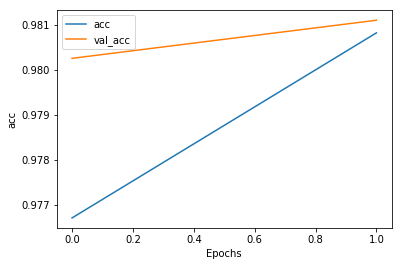

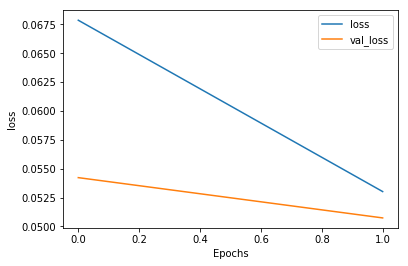

In [26]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [27]:
#test dataset 
sub_corpus = pd.read_csv('test.csv')
sub_corpus['comment_text'] = sub_corpus['comment_text'].map(lambda el : normalize_text(el))


In [28]:
sub_sequences = tokenizer_train.texts_to_sequences(sub_corpus['comment_text'])
padded_test_corpus = pad_sequences(sub_sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)


In [29]:
predictions = model.predict(padded_test_corpus)


In [30]:
submission = pd.read_csv("submission_LR.csv")
submission[toxic_columns] = predictions

submission.to_csv("submission_LSTM_glove.csv", index=False)


In [31]:
print('Kaggle LSTM with glove score -> 0.97062')

Kaggle LSTM with glove score -> 0.97062


In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='images/model_rnn_glove_plot.png', show_shapes=True, show_layer_names=True)